# Készíts egy osztályozási modellt: Finom ázsiai és indiai konyhák


## Konyhai osztályozók 1

Ebben a leckében különféle osztályozókat fogunk megvizsgálni, hogy *megjósoljuk egy adott nemzeti konyhát az összetevők csoportja alapján.* Eközben többet megtudunk arról, hogyan használhatók algoritmusok osztályozási feladatokhoz.

### [**Előadás előtti kvíz**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Előkészületek**

Ez a lecke az [előző leckénkre](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) épül, ahol:

-   Bevezetést tettünk az osztályozások világába egy adatállomány segítségével, amely Ázsia és India csodálatos konyháit mutatta be 😋.

-   Felfedeztünk néhány [dplyr igét](https://dplyr.tidyverse.org/) az adatok előkészítéséhez és tisztításához.

-   Gyönyörű vizualizációkat készítettünk a ggplot2 segítségével.

-   Bemutattuk, hogyan kezeljük az egyensúlyhiányos adatokat azok előfeldolgozásával a [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html) használatával.

-   Megmutattuk, hogyan lehet `prep` és `bake` funkciókat használni annak ellenőrzésére, hogy a recept megfelelően működik-e.

#### **Előfeltétel**

Ehhez a leckéhez az alábbi csomagokra lesz szükségünk az adatok tisztításához, előkészítéséhez és vizualizálásához:

-   `tidyverse`: A [tidyverse](https://www.tidyverse.org/) egy [R csomaggyűjtemény](https://www.tidyverse.org/packages), amely gyorsabbá, könnyebbé és szórakoztatóbbá teszi az adatfeldolgozást!

-   `tidymodels`: A [tidymodels](https://www.tidymodels.org/) keretrendszer egy [csomaggyűjtemény](https://www.tidymodels.org/packages/) modellezéshez és gépi tanuláshoz.

-   `themis`: A [themis csomag](https://themis.tidymodels.org/) extra lépéseket biztosít az egyensúlyhiányos adatok kezeléséhez.

-   `nnet`: Az [nnet csomag](https://cran.r-project.org/web/packages/nnet/nnet.pdf) funkciókat kínál egyetlen rejtett réteggel rendelkező előrecsatolt neurális hálózatok becsléséhez, valamint multinomiális logisztikai regressziós modellekhez.

A csomagokat az alábbi módon telepítheted:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternatívaként az alábbi script ellenőrzi, hogy rendelkezésre állnak-e a modul elvégzéséhez szükséges csomagok, és telepíti őket, ha hiányoznak.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Osszuk fel az adatokat tanuló- és tesztkészletekre.

Kezdjük néhány lépéssel az előző leckéből.

### Hagyjuk ki azokat a leggyakoribb hozzávalókat, amelyek zavart keltenek a különböző konyhák között, a `dplyr::select()` használatával.

Mindenki szereti a rizst, a fokhagymát és a gyömbért!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Tökéletes! Most osszuk fel az adatokat úgy, hogy 70%-uk a tanító, 30%-uk pedig a tesztelő adathalmazba kerüljön. Emellett alkalmazzunk egy `stratifikációs` technikát az adatok felosztásakor, hogy `megőrizzük az egyes konyhák arányát` a tanító és validációs adathalmazokban.

Az [rsample](https://rsample.tidymodels.org/) csomag a Tidymodels keretrendszerben hatékony adatfelosztási és újramintavételi infrastruktúrát biztosít:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Kezelés kiegyensúlyozatlan adatokkal

Ahogy az eredeti adathalmazban és a tanítóhalmazunkban is észrevehetted, a konyhák számának eloszlása meglehetősen egyenlőtlen. A koreai konyhák száma *majdnem* háromszorosa a thai konyhákénak. A kiegyensúlyozatlan adatok gyakran negatívan befolyásolják a modell teljesítményét. Sok modell akkor működik a legjobban, ha a megfigyelések száma egyenlő, és emiatt nehézségeik adódhatnak az egyenlőtlen adatokkal.

A kiegyensúlyozatlan adathalmazok kezelésére alapvetően két módszer létezik:

-   megfigyelések hozzáadása a kisebbségi osztályhoz: `Túlmintavételezés` (Over-sampling), például SMOTE algoritmus használatával, amely szintetikusan generál új példákat a kisebbségi osztályból az esetek legközelebbi szomszédai alapján.

-   megfigyelések eltávolítása a többségi osztályból: `Alulminta-vételezés` (Under-sampling)

Az előző leckénkben bemutattuk, hogyan lehet kiegyensúlyozatlan adathalmazokat kezelni egy `recept` segítségével. A receptet úgy lehet elképzelni, mint egy tervrajzot, amely leírja, milyen lépéseket kell alkalmazni egy adathalmazon ahhoz, hogy az készen álljon az adatelemzésre. A mi esetünkben azt szeretnénk elérni, hogy a konyhák száma egyenlően oszoljon el a `tanítóhalmazunkban`. Vágjunk is bele!


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Természetesen megerősítheted (prep+bake használatával), hogy a recept úgy működik, ahogy elvárod - az összes konyhai címkének `559` megfigyelése van.

Mivel ezt a receptet előfeldolgozóként fogjuk használni a modellezéshez, egy `workflow()` elvégzi helyettünk az összes előkészítést és sütést, így nem kell manuálisan becsülnünk a receptet.

Most készen állunk egy modell betanítására 👩‍💻👨‍💻!

## 3. A megfelelő osztályozó kiválasztása

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Illusztráció: @allison_horst</figcaption>


Most már el kell döntenünk, melyik algoritmust használjuk a feladathoz 🤔.

A Tidymodels-ben a [`parsnip csomag`](https://parsnip.tidymodels.org/index.html) egységes felületet biztosít a modellekkel való munkához különböző motorok (csomagok) között. Kérlek, nézd meg a parsnip dokumentációját, hogy felfedezd a [modell típusokat és motorokat](https://www.tidymodels.org/find/parsnip/#models), valamint a hozzájuk tartozó [modell argumentumokat](https://www.tidymodels.org/find/parsnip/#model-args). Az elején a választék meglehetősen zavarba ejtő lehet. Például az alábbi módszerek mind tartalmaznak osztályozási technikákat:

-   C5.0 szabályalapú osztályozási modellek

-   Rugalmas diszkrimináns modellek

-   Lineáris diszkrimináns modellek

-   Regularizált diszkrimináns modellek

-   Logisztikus regressziós modellek

-   Multinomiális regressziós modellek

-   Naiv Bayes modellek

-   Támogató vektorgépek

-   Legközelebbi szomszédok

-   Döntési fák

-   Együttes módszerek

-   Neurális hálózatok

És a lista folytatódik!

### **Melyik osztályozót válasszuk?**

Tehát, melyik osztályozót válasszuk? Gyakran az a módszer, hogy több modellt kipróbálunk, és keresünk egy jó eredményt.

> Az AutoML elegánsan megoldja ezt a problémát azáltal, hogy ezeket az összehasonlításokat a felhőben futtatja, lehetővé téve, hogy kiválaszd a legjobb algoritmust az adataidhoz. Próbáld ki [itt](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Az osztályozó választása azonban a problémánktól is függ. Például, ha az eredmény `több mint két kategóriába` sorolható, mint a mi esetünkben, akkor `többosztályos osztályozási algoritmust` kell használni, nem pedig `bináris osztályozást.`

### **Egy jobb megközelítés**

Egy jobb módszer, mint a vad találgatás, az, ha követjük az ötleteket ezen a letölthető [ML Cheat Sheet-en](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Itt felfedezhetjük, hogy a többosztályos problémánkhoz van néhány választási lehetőség:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>A Microsoft Algoritmus Cheat Sheet egy részlete, amely a többosztályos osztályozási lehetőségeket mutatja</figcaption>


### **Érvelés**

Nézzük meg, hogyan tudunk különböző megközelítéseket alkalmazni a rendelkezésre álló korlátok figyelembevételével:

-   **Mély neurális hálók túl nehezek**. Tekintve, hogy tiszta, de minimális adatállományunk van, és a tanítást helyben, notebookokon keresztül végezzük, a mély neurális hálók túlzottan erőforrásigényesek ehhez a feladathoz.

-   **Nincs kétosztályos osztályozó**. Nem használunk kétosztályos osztályozót, így az egy-az-összes ellen megközelítés nem jöhet szóba.

-   **Döntési fa vagy logisztikus regresszió működhet**. Egy döntési fa működhet, vagy multinomiális regresszió/multiosztályos logisztikus regresszió a többosztályos adatokhoz.

-   **Többosztályos Boosted Decision Trees más problémát old meg**. A többosztályos Boosted Decision Tree leginkább nemparaméteres feladatokra alkalmas, például rangsorok létrehozására, így számunkra nem hasznos.

Általában, mielőtt bonyolultabb gépi tanulási modellekbe, például ensemble módszerekbe kezdenénk, érdemes a legegyszerűbb modellt felépíteni, hogy megértsük, mi történik. Ezért ebben a leckében egy `multinomiális regresszió` modellel kezdünk.

> A logisztikus regresszió olyan technika, amelyet akkor használunk, ha az eredményváltozó kategóriális (vagy nominális). Bináris logisztikus regresszió esetén az eredményváltozók száma kettő, míg multinomiális logisztikus regresszió esetén az eredményváltozók száma kettőnél több. További információért lásd: [Haladó regressziós módszerek](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html).

## 4. Multinomiális logisztikus regresszió modell tanítása és értékelése

A Tidymodels-ben a `parsnip::multinom_reg()` egy olyan modellt határoz meg, amely lineáris prediktorokat használ a többosztályos adatok előrejelzésére a multinomiális eloszlás segítségével. Lásd `?multinom_reg()` a különböző módok/motorok megtekintéséhez, amelyekkel ezt a modellt illesztheted.

Ebben a példában egy multinomiális regresszió modellt illesztünk az alapértelmezett [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) motor segítségével.

> A `penalty` értékét véletlenszerűen választottam ki. Ennél vannak jobb módszerek az érték kiválasztására, például `resampling` és a modell `hangolása`, amelyről később fogunk beszélni.
>
> Lásd: [Tidymodels: Kezdő lépések](https://www.tidymodels.org/start/tuning/) ha többet szeretnél megtudni a modell hiperparamétereinek hangolásáról.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Szép munka 🥳! Most, hogy van egy receptünk és egy modell specifikációnk, meg kell találnunk a módját, hogy ezeket egy objektumba csomagoljuk, amely először előfeldolgozza az adatokat, majd illeszti a modellt az előfeldolgozott adatokra, és lehetőséget biztosít az esetleges utófeldolgozási tevékenységekre is. A Tidymodels-ben ezt a praktikus objektumot [`workflow`](https://workflows.tidymodels.org/) néven ismerjük, amely kényelmesen tárolja a modellezési komponenseidet! Ez az, amit *Python*-ban *pipelines*-nak neveznénk.

Tehát csomagoljunk mindent egy workflow-ba!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


A munkafolyamatok 👌👌! Egy **`workflow()`** hasonló módon illeszthető, mint egy modell. Tehát itt az ideje egy modell betanításának!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

A kimenet megmutatja azokat a tényezőket, amelyeket a modell a tanulás során elsajátított.

### A betanított modell értékelése

Itt az ideje, hogy megnézzük, hogyan teljesített a modell 📏, azáltal, hogy kiértékeljük egy tesztkészleten! Kezdjük azzal, hogy előrejelzéseket készítünk a tesztkészlet alapján.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Szép munka! A Tidymodels-ben a modell teljesítményének értékelése a [yardstick](https://yardstick.tidymodels.org/) segítségével végezhető el - egy csomag, amelyet a modellek hatékonyságának mérésére használnak teljesítménymutatók segítségével. Ahogy a logisztikus regresszió leckénkben tettük, kezdjük egy zavaró mátrix kiszámításával.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Amikor több osztállyal dolgozunk, általában intuitívabb ezt hőtérképként elképzelni, így:


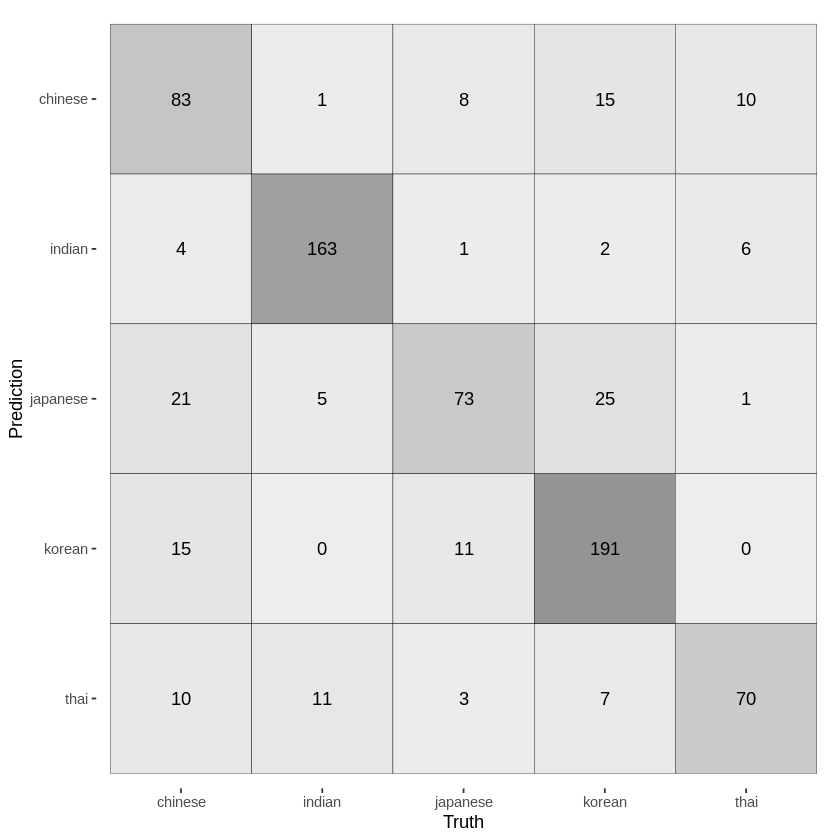

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

A zavaró mátrix diagram sötétebb négyzetei magas esetszámokat jelölnek, és remélhetőleg látható egy sötétebb négyzetekből álló átlós vonal, amely azokat az eseteket jelzi, ahol az előrejelzett és a valós címke megegyezik.

Most számítsuk ki a zavaró mátrix összegző statisztikáit.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Ha néhány metrikára, például pontosságra, érzékenységre, ppv-re szűkítjük a vizsgálatot, akkor kezdetnek nem állunk rosszul 🥳!

## 4. Mélyebb elemzés

Tegyük fel a következő finom kérdést: Milyen kritérium alapján választják ki egy adott típusú konyhát, mint előrejelzett eredményt?

Nos, a statisztikai gépi tanulási algoritmusok, mint például a logisztikus regresszió, `valószínűségen` alapulnak; tehát amit egy osztályozó ténylegesen előre jelez, az egy valószínűségi eloszlás a lehetséges kimenetek halmazán. Az a kategória, amelynek a legmagasabb a valószínűsége, kerül kiválasztásra, mint a legvalószínűbb eredmény az adott megfigyelések alapján.

Nézzük meg ezt működés közben, készítsünk kemény kategória előrejelzéseket és valószínűségeket is.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Meg tudnád magyarázni, miért gondolja a modell, hogy az első megfigyelés nagy valószínűséggel thai?

## **🚀Kihívás**

Ebben a leckében a megtisztított adataidat használtad fel egy gépi tanulási modell létrehozásához, amely képes megjósolni egy nemzeti konyhát az összetevők alapján. Szánj egy kis időt arra, hogy átnézd a [számos lehetőséget](https://www.tidymodels.org/find/parsnip/#models), amelyet a Tidymodels kínál az adatok osztályozására, valamint az [egyéb módszereket](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) a multinomiális regresszió illesztésére.

#### KÖSZÖNET ILLETI:

[`Allison Horst`](https://twitter.com/allison_horst/) az elképesztő illusztrációkért, amelyek barátságosabbá és vonzóbbá teszik az R nyelvet. További illusztrációkat találhatsz az ő [galériájában](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) és [Jen Looper](https://www.twitter.com/jenlooper) az eredeti Python verzió megalkotásáért ♥️

<br>
Dobtam volna be néhány viccet, de nem igazán értem az ételes szóvicceket 😅.

<br>

Jó tanulást kívánok,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Diák Nagykövet.



---

**Felelősség kizárása**:  
Ez a dokumentum az AI fordítási szolgáltatás, a [Co-op Translator](https://github.com/Azure/co-op-translator) segítségével lett lefordítva. Bár törekszünk a pontosságra, kérjük, vegye figyelembe, hogy az automatikus fordítások hibákat vagy pontatlanságokat tartalmazhatnak. Az eredeti dokumentum az eredeti nyelvén tekintendő hiteles forrásnak. Kritikus információk esetén javasolt professzionális emberi fordítást igénybe venni. Nem vállalunk felelősséget semmilyen félreértésért vagy téves értelmezésért, amely a fordítás használatából eredhet.
